# Markov chain Monte Carlo in the TrueSkill model

The goal of this question is to get you familiar with the basics of
Bayesian inference in medium-sized models with continuous latent variables, and the basics of Hamiltonian Monte Carlo.

## Background

We'll implement a variant of the [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2.
It is a generalization of the Elo rating system in Chess.

This assignment is based on [this one](http://mlg.eng.cam.ac.uk/teaching/4f13/1920/) developed by Carl Rasmussen at Cambridge for his course on probabilistic machine learning.

## Model definition
We'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are \emph{a priori} independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [1]:
%%capture
!pip install wget

import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch.distributions.normal import Normal

from functools import partial

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
  # axis=-1 means sum over the last dimension.
  m = Normal(mu, std)
  return torch.sum(m.log_prob(x), axis=-1)

## Q2.1 Implementing the TrueSkill Model (10 pts)

### Q 2.1.a [5 points]
Implement a function $\text{log\_joint\_prior}$ that computes the log of the prior, jointly evaluated over all player's skills.

Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, it returns a $K \times 1$ array, where each row contains a scalar giving the log-prior for that set of skills.


In [5]:
def log_joint_prior(zs_array):
  # Hint: Use diag_gaussian_log_density
  return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))


### Q 2.1.b [5 points]

Implement two functions $\text{logp\_a\_beats\_b}$ and $\text{logp\_b\_beats\_a}$.

Given a pair of skills $z_a$ and $z_b$, $\text{logp\_a\_beats\_b}$ evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above, and $\text{logp\_b\_beats\_a}$ is vice versa.

To ensure numerical stability, use the function $\text{torch.logaddexp}$.


In [6]:
def logp_a_beats_b(z_a, z_b):
  # Hint: Use torch.logaddexp
  return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def logp_b_beats_a(z_a, z_b):
# Hint: Use torch.logaddexp
  return -torch.logaddexp(torch.tensor([0.0]), z_a - z_b)

## Q 2.2 Examining the posterior for only two players and toy data (10 pts)
To get a feel for this model, we'll first consider the case where we only have 2 players, A and B.
We'll examine how the prior and likelihood interact when conditioning on different sets of games.

Provided in the starter code is a function `skillcontour` which evaluates a provided function on a grid of z_A and z_B's and plots the isocontours of that function.
As well, there is a function `plot_line_equal_skill`.
We have included an example of how you can use these functions.

We also provided a function `two_player_toy_games` which produces toy data for two players.
I.e., `two_player_toy_games(5,3)` produces a dataset where player A wins 5 games and player B wins 3 games.



In [2]:
# Plotting helper functions
def plot_isocontours(ax, func, steps=100):
    x = torch.linspace(-4, 4, steps=steps)
    y = torch.linspace(-4, 4, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    #Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z )
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()


### Q 2.2.a [3 points]
For two players $A$ and $B$, plot the isocontours of the joint prior over their skills.  Also plot the line of equal skill, $z_A = z_B$.  You've already implemented the log of this function, you just need to graph it using the helper function `plot_2d_fun` above.

For this and the following plots, label both axes.

According to the prior, what's the chance that player A is better than player B?

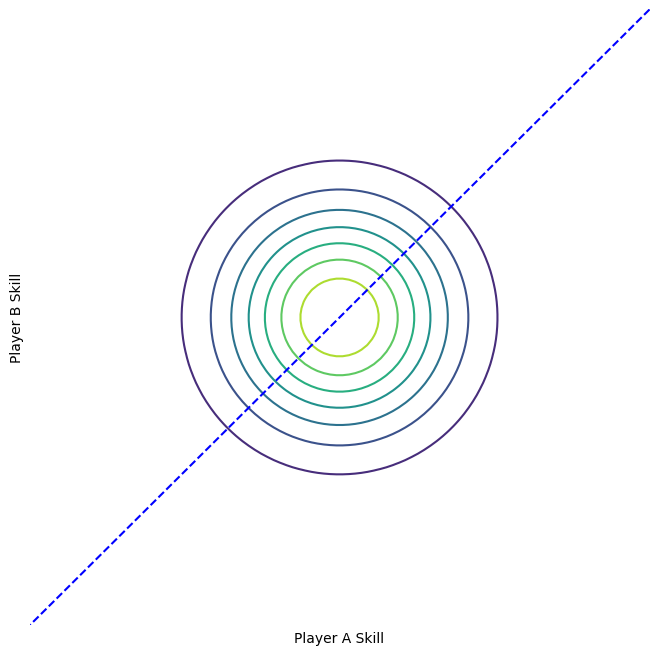

<Figure size 640x480 with 0 Axes>

In [3]:
import warnings
warnings.filterwarnings('ignore')
  
  
def log_prior_over_2_players(z1, z2):
  #return z1+z2
  m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
  return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
  
  return torch.exp(log_prior_over_2_players(z1, z2))

plot_2d_fun(prior_over_2_players, "Player A Skill", "Player B Skill")

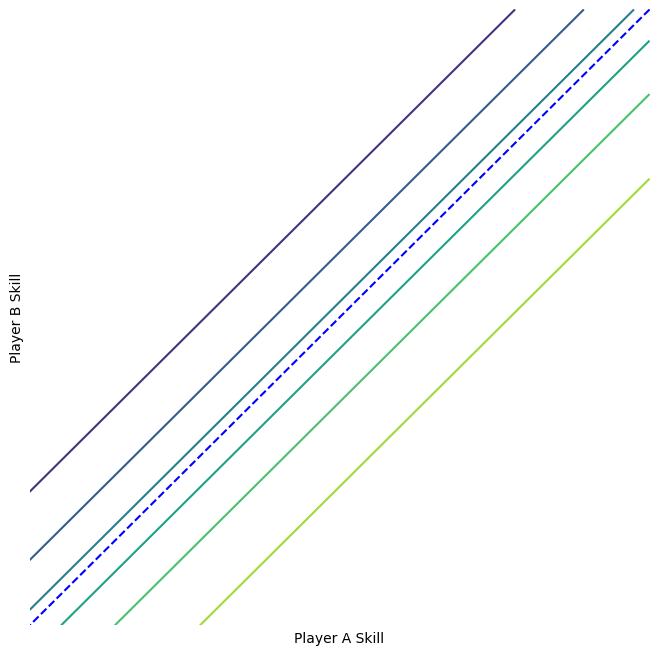

<Figure size 640x480 with 0 Axes>

In [10]:
# Note:  This isn't part of the assignment
def likelihood_over_2_players(z1, z2):
  return torch.exp(logp_a_beats_b(z1, z2))

plot_2d_fun(likelihood_over_2_players, "Player A Skill", "Player B Skill")

### Q 2.2.b [3 points]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that player A
beat player B in one match.  Since the contours don't depend on the normalization
constant, you can simply plot the isocontours of the log of joint distribution of
$p(z_A, z_B, \text{A beat B})$
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, which player is likely to have higher skill?

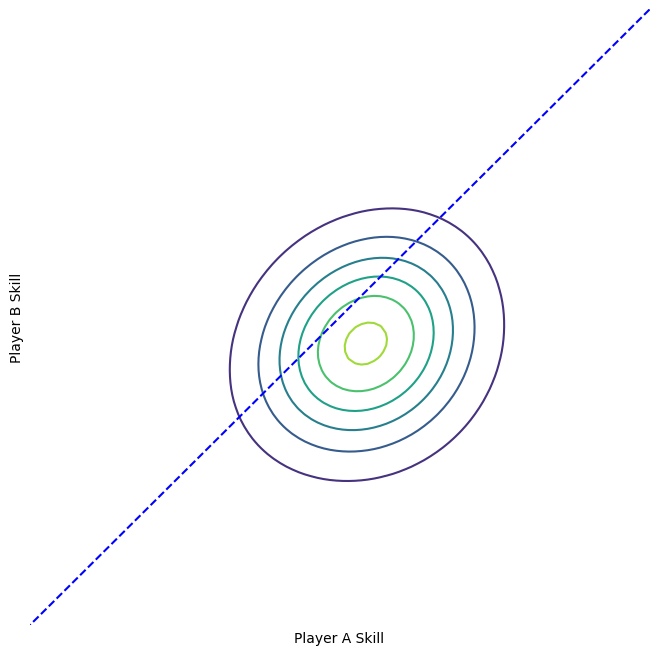

<Figure size 640x480 with 0 Axes>

In [11]:
def log_posterior_A_beat_B(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use the log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
  return torch.exp(log_posterior_A_beat_B(z1, z2))

plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill")

### Q 2.2.c [2 points]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
10 matches were played, and player A beat player B all 10 times.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it plausible that player B is more skilled than player A?

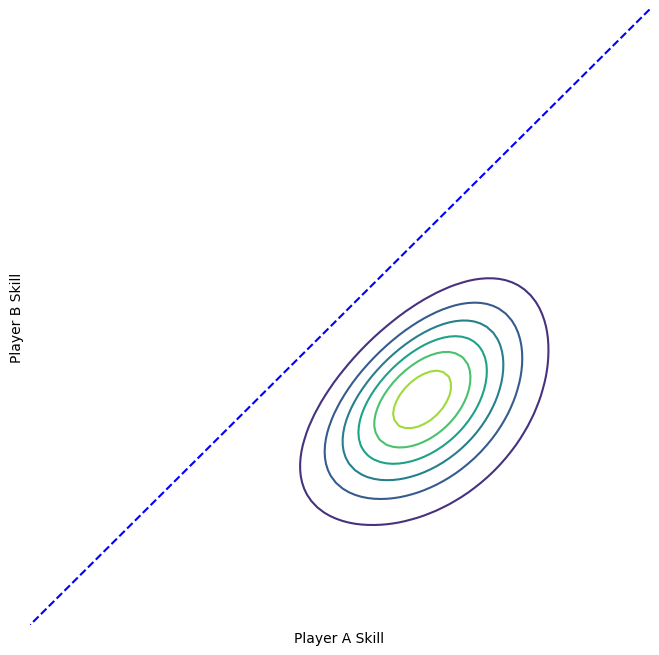

<Figure size 640x480 with 0 Axes>

In [12]:
def log_posterior_A_beat_B_10_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
  return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill")

### Q 2.2.d [2 point]

Plot isocontours of the joint posterior over $z_A$ and $z_B$ given that
20 matches were played, and each player beat the other 10 times.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it likely that one player is much better than another?  Is it plausible that both players are better than average?  Worse than average?

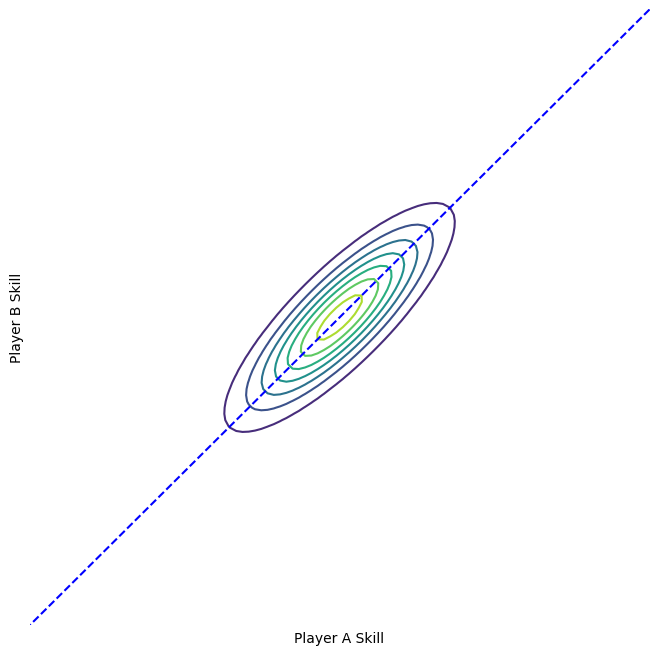

<Figure size 640x480 with 0 Axes>

In [13]:
def log_posterior_beat_each_other_10_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) \
+ 10.* logp_a_beats_b(z1, z2) \
+ 10.* logp_b_beats_a(z1, z2)

def posterior_beat_each_other_10_times(z1, z2):
  return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))
plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill")

## Q 2.3 Hamiltonian Monte Carlo on Two Players and Toy Data (6 points)

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.
Carl Rasmussen's assignment uses Gibbs sampling.

In this question we will  approximate posterior distributions with gradient-based Hamiltonian Monte Carlo.

In the next assignment, we'll use gradient-based stochastic variational inference, which wasn't invented until around 2014.


In [17]:
random.seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [18]:
# Hamiltonian Monte Carlo
from tqdm import trange, tqdm_notebook  # Progress meters

def leapfrog(params_t0, momentum_t0, stepsize, logprob_grad_fun):
  # Performs a reversible update of parameters and momentum
  # See https://en.wikipedia.org/wiki/Leapfrog_integration
  momentum_thalf = momentum_t0    + 0.5 * stepsize * logprob_grad_fun(params_t0)
  params_t1 =      params_t0      +       stepsize * momentum_thalf
  momentum_t1 =    momentum_thalf + 0.5 * stepsize * logprob_grad_fun(params_t1)
  return params_t1, momentum_t1


def iterate_leapfrogs(theta, v, stepsize, num_leapfrog_steps, grad_fun):
  for i in range(0, num_leapfrog_steps):
    theta, v = leapfrog(theta, v, stepsize, grad_fun)
  return theta, v

def metropolis_hastings(state1, state2, log_posterior):
  # Compares the log_posterior at two values of parameters,
  # and accepts the new values proportional to the ratio of the posterior
  # probabilities.
  accept_prob = torch.exp(log_posterior(state2) - log_posterior(state1))
  if random.random() < accept_prob:
    return state2  # Accept
  else:
    return state1  # Reject

def draw_samples(num_params, stepsize, num_leapfrog_steps, n_samples, log_posterior):
  theta = torch.zeros(num_params)

  def log_joint_density_over_params_and_momentum(state):
    params, momentum = state
    return diag_gaussian_log_density(momentum, torch.zeros_like(momentum), torch.ones_like(momentum)) \
     + log_posterior(params)

  def grad_fun(zs):
    zs = zs.detach().clone()
    zs.requires_grad_(True)
    y = log_posterior(zs)
    y.backward()
    return zs.grad

  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(theta)

    momentum = torch.normal(0, 1, size = np.shape(theta))

    theta_new, momentum_new = iterate_leapfrogs(theta, momentum, stepsize, num_leapfrog_steps, grad_fun)

    theta, momentum = metropolis_hastings((theta, momentum), (theta_new, momentum_new), log_joint_density_over_params_and_momentum)
  return torch.stack((sampleslist))


### Q 2.3.a [Free]

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 1 game.

100%|██████████| 2000/2000 [00:10<00:00, 184.29it/s]


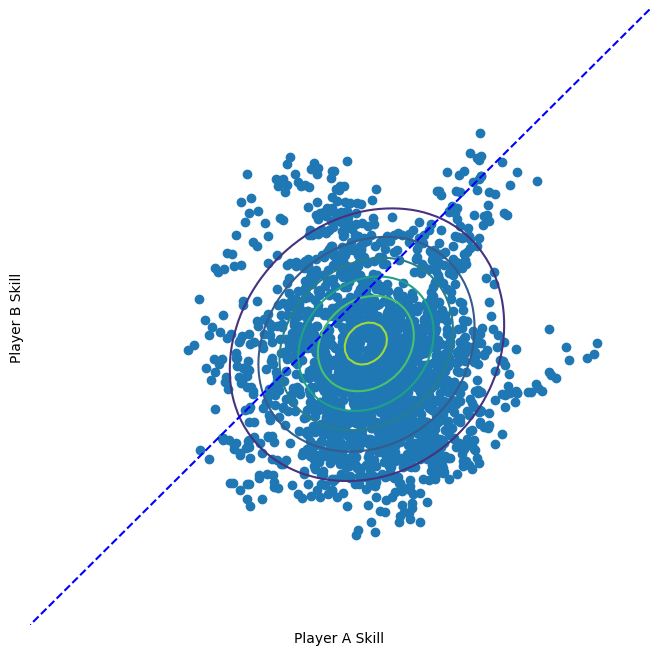

<Figure size 640x480 with 0 Axes>

In [19]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2000
stepsize = 0.01


def log_posterior_a(zs):
  return log_posterior_A_beat_B(zs[0], zs[1])

samples_a = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_a)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_a)

### Q 2.3.b [3 point]

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 10 games against player B.  Hint:  You can re-use the code from when you plotted the isocontours.

100%|██████████| 2000/2000 [00:11<00:00, 180.47it/s]


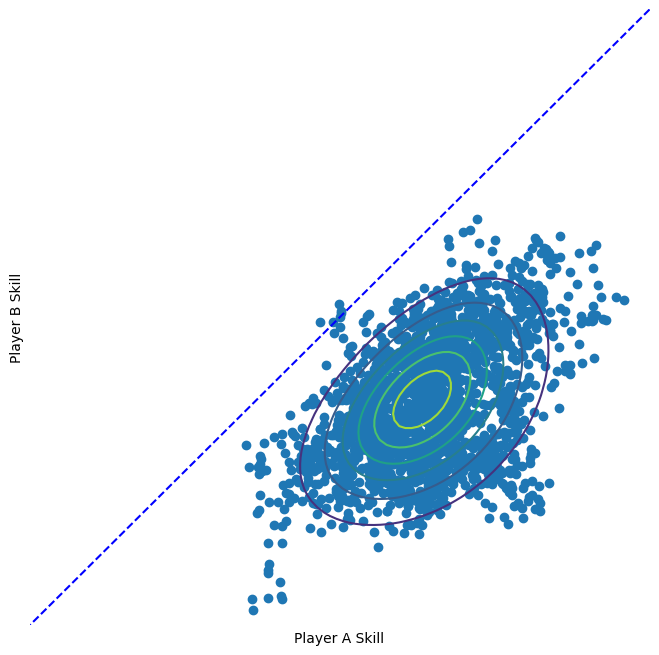

<Figure size 640x480 with 0 Axes>

In [20]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2000
stepsize = 0.01
key = 42


def log_posterior_b(zs):
  (z1, z2) = zs
  return log_posterior_A_beat_B_10_times(z1, z2)

samples_b = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_b)
ax = plot_2d_fun(posterior_A_beat_B_10_times, 'Player A Skill', 'Player B Skill', samples_b)

### Q 2.3.c [3 points]

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 10 games and player B winning 10 games.

100%|██████████| 2000/2000 [00:13<00:00, 148.66it/s]


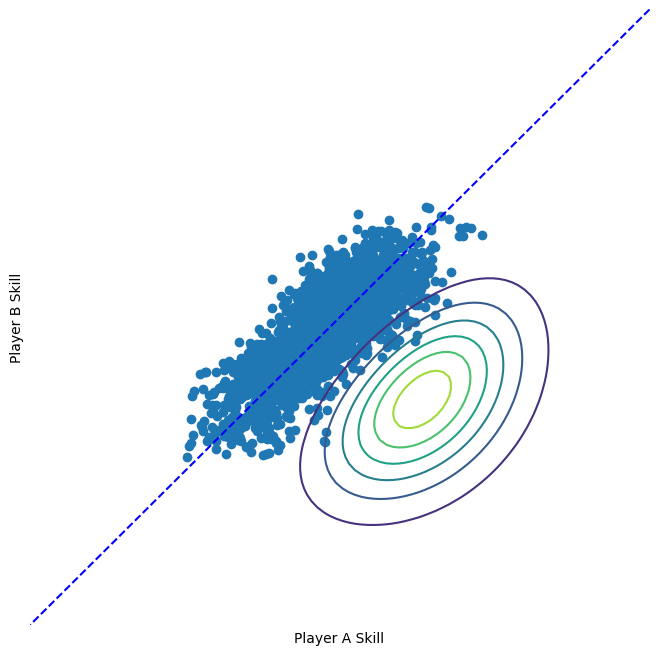

<Figure size 640x480 with 0 Axes>

In [21]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2000
stepsize = 0.01


def log_posterior(zs):
  (z1, z2) = zs
  return log_posterior_beat_each_other_10_times(z1, z2)

samples_c = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior)
ax = plot_2d_fun(posterior_A_beat_B_10_times, 'Player A Skill', 'Player B Skill', samples_c)

## Q 2.4 Approximate inference conditioned on real data [26 points]

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [22]:
wget.download("https://erdogdu.github.io/sta414/hw/hw2/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://erdogdu.github.io/sta414/hw/hw2/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

In [23]:
games = torch.IntTensor(games)

### Q 2.4.a.1 [4 points]

Assuming all game outcomes are i.i.d. conditioned on all players' skills, implement a function `log_games_likelihood` that takes a batch of player skills `zs` and a collection of observed games `games` and gives the total log-likelihoods for all those observations given all the skills.

Hint: You should be able to write this function without using `for` loops, although you might want to start that way to make sure what you've written is correct.  If \( A \) is an array of integers, you can index the corresponding entries of another matrix \( B \) for every entry in \( A \) by writing `B[A]`.


In [24]:
def log_games_likelihood(zs, games):
  
  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]
  winning_player_skills = zs[winning_player_ixs]
  losing_player_skills = zs[losing_player_ixs]
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
  return torch.sum(log_likelihoods, axis=0)



## Q 2.4.a.2) [3 points]
Implement a function `joint_log_density` which combines the log-prior and log-likelihood of the observations to give \( p(z_1, z_2, \dots, z_N, \text{all game outcomes}) \)


In [25]:
def log_joint_probability(zs, games):
    return log_games_likelihood(zs, games) + log_joint_prior(zs)

### Q 2.4.b [3 points]
Run Hamiltonian Monte Carlo on the posterior over all skills conditioned on all the tennis games from the dataset.  Run for 10000 samples.

In [26]:
# Hyperparameters
num_players = 1434
num_leapfrog_steps = 20
n_samples = 10000
stepsize = 0.01

#Hint: you will need to use games
def log_posterior(zs):
  return log_joint_prior(zs) + log_games_likelihood(zs, games)

all_games_samples = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior)

100%|██████████| 10000/10000 [01:10<00:00, 141.13it/s]


### Q 2.4.c [3 points]
Based on your samples from the previous question, plot the approximate mean and variance of the marginal skill of each player, sorted by average skill. There's no need to include the names of the players.  Label the axes "Player Rank", and "Player Skill".

<ErrorbarContainer object of 3 artists>

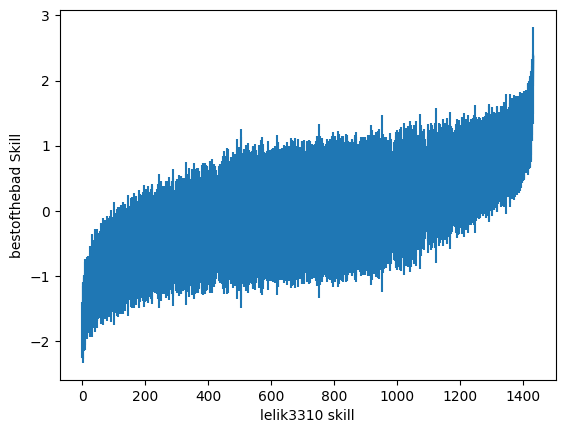

In [27]:
mean_skills = torch.mean( all_games_samples, axis = 0)
var_skills = torch.var( all_games_samples, axis = 0)

order = np.argsort(mean_skills)

plt.xlabel("lelik3310 skill")
plt.ylabel("bestofthebad Skill")
plt.errorbar(range(num_players), mean_skills[order], var_skills[order])

### Q 2.4.d [3 point]
List the names of the 5 players with the lowest mean skill and 5 players with the highest mean skill according to your samples.  Hint: you can re-use `order` from the previous question.

In [28]:
# Names of 5 players with the lowest mean skill
lowest_players = names[order[:5], 1]

# Names of 5 players with the highest mean skill
highest_players = names[order[-5:], 1]

print("5 players with the lowest mean skill:")
for player in lowest_players:
    print(player)

print("\n5 players with the highest mean skill:")
for player in highest_players:
    print(player)

5 players with the lowest mean skill:
italiantranslator
thebestofthebad
duckduckfrog
vkmansftw
kylecuver1

5 players with the highest mean skill:
hick4u1219
mrzoom47
cdvh
laode_syahril
doraemon61


### Q 2.4.e [3 point]
Use a scatterplot to show your samples from the joint posterior over the skills of lelik3310 and thebestofthebad.  Include the line of equal skill.  Hint: you can use `plt.scatter`.


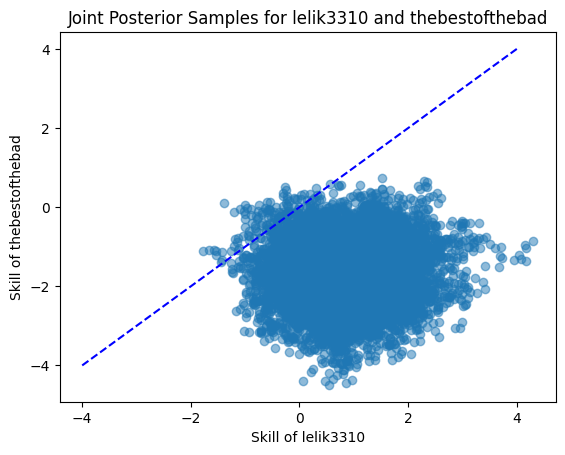

In [29]:
# Find the indices of the two players
index_lelik3310 = np.where(names[:, 1] == "lelik3310")[0][0]
index_thebestofthebad = np.where(names[:, 1] == "thebestofthebad")[0][0]

# Extract samples for these two players
samples_lelik3310 = all_games_samples[:, index_lelik3310]
samples_thebestofthebad = all_games_samples[:, index_thebestofthebad]

# Scatterplot
plt.scatter(samples_lelik3310, samples_thebestofthebad, alpha=0.5)
plt.plot([-4, 4], [-4, 4], 'b--')  # Line of equal skill
plt.xlabel("Skill of lelik3310")
plt.ylabel("Skill of thebestofthebad")
plt.title("Joint Posterior Samples for lelik3310 and thebestofthebad")
plt.show()

### Q 2.4.f [3 points]
Using your samples, find the players that have the eleventh highest mean skill. Print an unbiased estimate of the probability that the player with the eleventh highest highest mean skill is not worse than lelik3310, again as estimated from your samples.  Hint: Probabilities of Bernoulli random variables can be written as the expectation that the Bernoulli takes value 1, so you can use simple Monte Carlo.  The final formula will be very simple.

In [31]:
# Identify the player with the eleventh highest mean skill
index_eleventh_highest = order[-11]
name_eleventh_highest = names[index_eleventh_highest, 1]

print(f"Player with the eleventh highest mean skill: {name_eleventh_highest}")

# Extract samples for the eleventh highest player
samples_eleventh_highest = all_games_samples[:, index_eleventh_highest]

# Estimate the probability that the eleventh highest player is not worse than lelik3310
prob_not_worse_than_lelik3310 = torch.mean((samples_eleventh_highest >= samples_lelik3310).float()).item()

print(f"Probability that {name_eleventh_highest} is not worse than lelik3310: {prob_not_worse_than_lelik3310:.4f}")


Player with the eleventh highest mean skill: great-mate-super-gre
Probability that great-mate-super-gre is not worse than lelik3310: 0.6916


### Q 2.4.g [2 points]

For any two players $i$ and $j$, $p(z_i, z_j | \text{all games})$ is always proportional to $p(z_i, z_j , \text{all games})$, as a function of $z_i$ and $z_j$.

In general, are the isocontours of $p(z_i, z_j | \text{all games})$ the same as those of $p(z_i, z_j | \text{games between $i$ and $j$})$?  That is, do the games between other players besides $i$ and $j$ provide information about the skill of players $i$ and $j$?  A simple yes or no suffices.

Hint: One way to answer this is to draw the graphical model for three players, $i$, $j$, and $k$, and the results of games between all three pairs, and then examine conditional independencies.  If you do this, include the graphical models in your assignment. 

**Answer:** *Yes*.

**Explanation**:

In a Bayesian graphical model that represents the relationships between players' skills and game outcomes:

- Consider three players, $i$, $j$, and $k$.
- The games between $i$ and $k$ as well as between $j$ and $k$ can provide information about the relative skills of $i$ and $j$.
- The reason is that the relative skill of $i$ and $j$ might be inferred indirectly through their respective performances against a common opponent, $k$.
- As a result, the isocontours of $(z_i, z_j | \text{all games})$ aren't necessarily the same as those of $p(z_i, z_j | \text{games between } i \text{ and } j)$.
- Thus, games involving other players can indeed provide some information about the skills of players $i$ and $j$.

